In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random, timeit, copy

from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Flatten, LSTM
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.backend import clear_session

Using TensorFlow backend.


# Helper functions

In [2]:
letters=[chr(i) for i in range(97,123)]
digits=[str(i) for i in range(10)]

In [3]:
char_to_n=dict(zip(letters+digits+[" "],[a for a in range(len(letters))]+len(digits)*[len(letters)]+[len(letters)+1]))   
n_to_char=dict(zip([a for a in range(len(letters))]+[len(letters)]+[len(letters)+1],letters+['0']+[' ']))  
n_tokens = 28

two_grams = []
for a in letters:
    for b in letters:
        two_grams.append(a+b)
three_grams = []
for a in letters:
    for b in letters:
        for c in letters:
            three_grams.append(a+b+c)

two_gram_to_n = dict(zip(two_grams,range(26*26)))
three_gram_to_n = dict(zip(three_grams,range(26*26*26)))

In [4]:
def alphabetize(inText):
    """Make string lowercase, remove everything except letters"""
    outText=""
    inText=inText.lower() #Make lowercase
    for character in inText:
        if character in letters: outText+=character
        elif character in digits: outText+=''
        else: outText+=" "
    return " ".join(outText.split())

In [5]:
def vectorize(string):
    """Take a string as input and return an array of integers corresponding to each character's value"""
    out=[char_to_n[char] for char in string]
    return np.array(out)

In [6]:
def rot(sentence, n=13):
    tokens = []
    for a in sentence:
        old_token = char_to_n[a]
        if old_token < 26: tokens += [(old_token + n) % 26]
        else: tokens += [old_token]
    cipher_text = "".join([n_to_char[a] for a in tokens])
    return cipher_text  

In [7]:
def jumble(sentence, seed=0):
    random.seed(seed)
    target_characters = random.sample(letters,26)
    key = dict(zip(letters+['0'], target_characters+['0']))
    jumbled_sentence = "".join(key[char] for char in sentence)
    return jumbled_sentence, target_characters

In [8]:
def get_frequency_list(string):
    tokenized_text = [char_to_n[a] for a in string]
    frequencies = [tokenized_text.count(a)/len(tokenized_text) for a in range(n_tokens)]
    return frequencies

In [9]:
def get_twogram_frequencies(string):
    string_two_grams = [string[i:i+2] for i in range(len(string)-1)]
    tokenized_two_gram = [two_gram_to_n[char] for char in string_two_grams]
    frequencies = np.zeros(26*26)
    for token in tokenized_two_gram:
        frequencies[token]+= 1./len(tokenized_two_gram)
    #frequencies = [tokenized_two_gram.count(tg)/len(tokenized_two_gram) for tg in range(26*26)]
    return frequencies

In [10]:
def get_threegram_frequencies(string):
    string_three_grams = [string[i:i+3] for i in range(len(string)-2)]
    tokenized_three_gram = [three_gram_to_n[char] for char in string_three_grams]
    frequencies = np.zeros(26*26*26)
    for token in tokenized_three_gram:
        frequencies[token]+= 1./len(tokenized_three_gram)
    #frequencies = [tokenized_three_gram.count(tg)/len(tokenized_three_gram) for tg in range(26*26*26)]
    return frequencies

In [11]:
def string_accuracy(string1, string2):
    accuracy = np.sum(np.array(list(string1)) == np.array(list(string2)))/len(string1)
    wrong_characters = np.unique(np.array(list(string1))[np.where(np.array(list(string1)) != np.array(list(string2)))])
    return accuracy, wrong_characters

# Data loading and processing

In [12]:
files=['moby10b.txt','dracula.txt','totc.txt','origin.txt']#,'alice.txt','pp.txt','cw.txt']
raw_sample_text=""
for filename in files:
    with open(filename,'r') as file:
        raw_sample_text+=file.read().replace('\n', ' ')
processed_text = alphabetize(raw_sample_text)
text_nospace = "".join(processed_text.split())

In [13]:
strings =[text_nospace[T_x*(i) : T_x*(i+1)] for i in range(m)]


keys = np.random.randint(0, 26, m//2)
encrypted_strings_caesar = [rot(string, key) for string, key in zip(strings, keys)]
encrypted_strings_jumbled = []
jumbled_keys = []
#unencrypted_strings = []
Y = np.zeros((2*(m//2),1))

for i in range(m//2):
    current_string, current_key = jumble(strings[2*i],i)
    encrypted_strings_jumbled.append(current_string)
    jumbled_keys.append([char_to_n[char] for char in current_key])
    encrypted_strings_jumbled.append(strings[2*i+1])
    Y[2*i,0] = 1.
    Y[2*i+1] = 0.

jumbled_keys_oh = to_categorical(jumbled_keys, num_classes=26)

X = np.array([get_frequency_list(string) for string in encrypted_strings_jumbled])

X2 = np.array([get_twogram_frequencies(string) for string in encrypted_strings_jumbled])

X3 = np.array([get_threegram_frequencies(string) for string in encrypted_strings_jumbled])


keys_caesar = to_categorical(keys, num_classes = 26)
keys_long=to_categorical((np.tile(np.arange(26),(m//2,1))+keys.reshape((-1,1)))%26, num_classes=26)


print(f"Shape of X:{X.shape}")
print(f"Shape of X2:{X2.shape}")
print(f"Shape of X3:{X3.shape}")
print(f"Shape of Y:{Y.shape}")
print(f"Shape of keys_caesar:{keys_caesar.shape}")
print(f"Shape of keys_long:{keys_long.shape}")

NameError: name 'm' is not defined

In [14]:
def encrypt_half_text(T_x):
    m = len(text_nospace)//T_x 
    strings =[text_nospace[T_x*(i) : T_x*(i+1)] for i in range(m)]

    return_strings = []
    keys = []
    
    for i in range(m//2): #Encrypt half the strings
        current_string, current_key = jumble(strings[2*i],i)
        return_strings.append(current_string)
        keys.append([char_to_n[char] for char in current_key])
        return_strings.append(strings[2*i+1])
    
    return return_strings, keys
        

In [15]:
X_lstm = encrypt_half_text(1024)[0]
X = np.array([get_threegram_frequencies(string) for string in X_lstm])
X_lstm_oh = np.array([to_categorical([char_to_n[a] for a in string], num_classes=26) for string in X_lstm])
Y = np.array(int(len(X)/2)*[1,0]).reshape((-1,1))

In [16]:
theoretical_frequencies = get_threegram_frequencies(text_nospace)

# Network configuration and training

In [1415]:
def make_classifyer(units):
    classifyer_input = Input(shape=(26*26*26,))
    #classifyer_dense = Dense(units,activation='relu')(classifyer_input)
    #classifyer_drop = Dropout(0.4)(classifyer_dense)
    classifyer_out = Dense(1, activation='sigmoid')(classifyer_input)

    return Model(classifyer_input, classifyer_out)

In [812]:
def make_lstm_classifyer(units):
    lstm_input = Input(shape=(None,26))
    lstm_layer = LSTM(units)(lstm_input)
    lstm_drop = Dropout(0.3)(lstm_layer)
    lstm_layer2 = Dense(128, activation='relu')(lstm_drop)
    lstm_out = Dense(1, activation='sigmoid')(lstm_layer2)
    
    return Model(lstm_input, lstm_out)    

In [1106]:
lstm_classifyer = make_lstm_classifyer(512)
lstm_classifyer.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_classifyer.fit(X_lstm_oh,Y,epochs=10,validation_split=0.1)

KeyboardInterrupt: 

In [1420]:
classifyer = make_classifyer(1)
classifyer.compile(optimizer='Adam', loss='binary_crossentropy',metrics=['accuracy'])
classifyer.fit(X,Y,epochs=200,validation_split=0.2)

Train on 2302 samples, validate on 576 samples
Epoch 1/200
2302/2302 [==============================] - 0s 100us/step - loss: 0.6838 - accuracy: 0.9865 - val_loss: 0.6742 - val_accuracy: 1.0000
Epoch 2/200
2302/2302 [==============================] - 0s 80us/step - loss: 0.6653 - accuracy: 1.0000 - val_loss: 0.6561 - val_accuracy: 1.0000
Epoch 3/200
2302/2302 [==============================] - 0s 79us/step - loss: 0.6473 - accuracy: 1.0000 - val_loss: 0.6384 - val_accuracy: 1.0000
Epoch 4/200
2302/2302 [==============================] - 0s 82us/step - loss: 0.6298 - accuracy: 1.0000 - val_loss: 0.6213 - val_accuracy: 1.0000
Epoch 5/200
2302/2302 [==============================] - 0s 79us/step - loss: 0.6128 - accuracy: 1.0000 - val_loss: 0.6047 - val_accuracy: 1.0000
Epoch 6/200
2302/2302 [==============================] - 0s 79us/step - loss: 0.5964 - accuracy: 1.0000 - val_loss: 0.5886 - val_accuracy: 1.0000
Epoch 7/200
2302/2302 [==============================] - 0s 78us/step - loss

2302/2302 [==============================] - 0s 78us/step - loss: 0.1671 - accuracy: 1.0000 - val_loss: 0.1666 - val_accuracy: 1.0000
Epoch 57/200
2302/2302 [==============================] - 0s 78us/step - loss: 0.1632 - accuracy: 1.0000 - val_loss: 0.1627 - val_accuracy: 1.0000
Epoch 58/200
2302/2302 [==============================] - 0s 79us/step - loss: 0.1593 - accuracy: 1.0000 - val_loss: 0.1589 - val_accuracy: 1.0000
Epoch 59/200
2302/2302 [==============================] - 0s 81us/step - loss: 0.1556 - accuracy: 1.0000 - val_loss: 0.1552 - val_accuracy: 1.0000
Epoch 60/200
2302/2302 [==============================] - 0s 78us/step - loss: 0.1519 - accuracy: 1.0000 - val_loss: 0.1516 - val_accuracy: 1.0000
Epoch 61/200
2302/2302 [==============================] - 0s 78us/step - loss: 0.1484 - accuracy: 1.0000 - val_loss: 0.1481 - val_accuracy: 1.0000
Epoch 62/200
2302/2302 [==============================] - 0s 78us/step - loss: 0.1449 - accuracy: 1.0000 - val_loss: 0.1446 - val_a

Epoch 112/200
2302/2302 [==============================] - 0s 78us/step - loss: 0.0462 - accuracy: 1.0000 - val_loss: 0.0467 - val_accuracy: 1.0000
Epoch 113/200
2302/2302 [==============================] - 0s 77us/step - loss: 0.0452 - accuracy: 1.0000 - val_loss: 0.0457 - val_accuracy: 1.0000
Epoch 114/200
2302/2302 [==============================] - 0s 81us/step - loss: 0.0442 - accuracy: 1.0000 - val_loss: 0.0447 - val_accuracy: 1.0000
Epoch 115/200
2302/2302 [==============================] - 0s 79us/step - loss: 0.0433 - accuracy: 1.0000 - val_loss: 0.0437 - val_accuracy: 1.0000
Epoch 116/200
2302/2302 [==============================] - 0s 77us/step - loss: 0.0423 - accuracy: 1.0000 - val_loss: 0.0428 - val_accuracy: 1.0000
Epoch 117/200
2302/2302 [==============================] - 0s 77us/step - loss: 0.0414 - accuracy: 1.0000 - val_loss: 0.0418 - val_accuracy: 1.0000
Epoch 118/200
2302/2302 [==============================] - 0s 77us/step - loss: 0.0405 - accuracy: 1.0000 - val_

2302/2302 [==============================] - 0s 78us/step - loss: 0.0140 - accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 1.0000
Epoch 168/200
2302/2302 [==============================] - 0s 78us/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 1.0000
Epoch 169/200
2302/2302 [==============================] - 0s 78us/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.0138 - val_accuracy: 1.0000
Epoch 170/200
2302/2302 [==============================] - 0s 80us/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 171/200
2302/2302 [==============================] - 0s 77us/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 1.0000
Epoch 172/200
2302/2302 [==============================] - 0s 77us/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 173/200
2302/2302 [==============================] - 0s 77us/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.0127 -

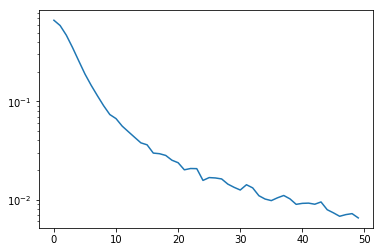

In [1349]:
plt.plot(classifyer.history.history['loss'])
plt.yscale('log')

In [17]:
files=['cw.txt']
raw_test_text=""
for filename in files:
    with open(filename,'r') as file:
        raw_test_text+=file.read().replace('\n', ' ')
processed_test_text = alphabetize(raw_test_text)
test_text_nospace = "".join(processed_test_text.split())

In [18]:
test_string =test_text_nospace[2700:2700+1024]

In [19]:
test_key = random.sample(letters,26)

In [20]:
test_string_encrypted = "".join([dict(zip(letters,test_key))[a] for a in test_string])
print(test_string_encrypted)

cxdtbmcaqbosovcnpqggqbmojbuszpcbovtboqbmpqovovcwtamcnnsbnvccnkszocagsddqcjbajdqkcovcwtamcnajtmvocznsbdsbmopqdqmvoszcjzdigszbqbmzjgldcnsbpqbozibqmvonvcdjijoovcwtamcnrccolcrszcovczsjzqbmdqlzjzirqzcvckjzzqcaovcwtamcnmzjbansbnsbvqnljkuszzsddcaovcgqbovcmzjnnjbamtjzacaovcqzrssonocxnovzstmvpqdajahcbotzcnaspbosovcrstbojqbqbovcnojldcijzajbachcblcisbapvczcovcxjaaskunpczcjbaovclczzixjokvcnjgsbmovcoczzqcznvcnojducaqgxczqstndijbaossonjbainjlcdvctooczdiqmbszcarszvcpjnuqbmuqbmshczjddkzccxqbmkzjpdqbmrdiqbmovqbmnsrwtamcgqddcznxdjkcvtgjbnqbkdtacavqnrjovczcdgsjvtmcnolczbjzavjalccbovcwtamcnqbncxjzjldcksgxjbqsbjbaltkulqarjqzosrsddspqbovcpjisrvqnrjovczvcpjnbsonsdjzmcvcpcqmvcasbdisbcvtbazcajbarszoixstbanrszvqngsovcznvcxvjalccbjnksokvnvcxvczaasmbchczovcdcnnsbcvtbazcajbarszoixstbanospvqkvpjnjaacaovcaqmbqoiovjoksgcnsrmssadqhqbmjbatbqhcznjdzcnxckocbjldcavqgoskjzzivqgncdrqbzqmvozsijdrjnvqsbatzqbmovcrstzicjznnqbkcvqnxtxxivssavcvjadqhcaovcdqrcsrjnjocajzqnoskzjovcvjajrqbcxzqacqbvqgncdrpjnchcbjozqrdccmsoqnoqkjdjnkstb

In [1421]:
print(classifyer.predict(np.array(get_threegram_frequencies(test_string)).reshape((1,-1)))[0,0])
print(classifyer.predict(np.array(get_threegram_frequencies(test_string_encrypted)).reshape((1,-1)))[0,0])

0.008313239
0.98504084


In [52]:
def decrypt(encrypted_string, n_iter=10, n_flips=1000, lstm=False):
    scores = []
    attempted_strings = []
    for k in range(n_iter):
        current_string = encrypted_string
        if lstm==False: current_score = 2.-np.sum(np.abs(get_threegram_frequencies(current_string)-theoretical_frequencies))#classifyer.predict(np.array(get_threegram_frequencies(current_string)).reshape((1,-1)))[0,0]
       # else: current_score = lstm_classifyer.predict(to_categorical(vectorize(current_string),num_classes=26).reshape((1,256,26)))[0,0]

    
        for i in range(n_flips):
        #random.seed()
            flip_a, flip_b = random.sample(letters,2)
            candidate_string = current_string.replace(flip_a, flip_b.upper()).replace(flip_b,flip_a.upper()).lower()
            if lstm==False: candidate_score = 2.-np.sum(np.abs(get_threegram_frequencies(candidate_string)-theoretical_frequencies))#classifyer.predict(np.array(get_threegram_frequencies(candidate_string)).reshape((1,-1)))[0,0]
           # else: candidate_score = lstm_classifyer.predict(to_categorical(vectorize(candidate_string),num_classes=26).reshape((1,256,26)))[0,0]
            if candidate_score > current_score:
                current_string = candidate_string
                current_score = candidate_score
     
        #if i%100 == 0: print(i)
            scores.append(current_score)
        print(f"Iteration {k+1} of {n_iter}. Score:{1-current_score}")
        attempted_strings.append(current_string)
    return attempted_strings[np.argmax(scores)//n_flips], np.max(scores)

In [53]:
attempt, scores = decrypt(test_string_encrypted,n_iter=5,n_flips=3000,lstm=False)

Iteration 1 of 5. Score:0.3539227090248436
Iteration 2 of 5. Score:0.19553213985346618
Iteration 3 of 5. Score:0.641272916087829
Iteration 4 of 5. Score:0.19553213985346618
Iteration 5 of 5. Score:0.19553213985346618


In [54]:
string_accuracy(attempt,test_string)

(0.994140625, array(['q'], dtype='<U1'))

In [21]:
class IndividualKey:
    
    def __init__(self, parent1=None, parent2=None, pivot_point=None):
        
        if parent1 is None: parent1 = np.random.permutation(26)
        if parent2 is None: parent2 = np.random.permutation(26)
        if pivot_point is None: pivot_point = np.random.randint(25)     
        
        self.key = np.zeros(26, dtype='int')

        parent1_contribution = np.copy(parent1[:pivot_point])
        parent2_contribution = np.copy(parent2[pivot_point:])
        fillers = list(set(np.arange(26))-set(parent1_contribution)-set(parent2_contribution))
        
        for i, element in enumerate(parent2_contribution):
            if element in parent1_contribution:
                parent2_contribution[i] = fillers.pop()

        self.key[:pivot_point] = parent1_contribution
        self.key[pivot_point:] = parent2_contribution
        
        assert len(np.unique(self.key))==26

    
    def mutate(self):
        c1, c2 = np.random.choice(26, 2, replace=False)
        self.key[c1], self.key[c2] = self.key[c2], self.key[c1]
    
    def decrypt(self, text):
        plaintext = "".join([n_to_char[self.key[char_to_n[a]]] for a in alphabetize(text)])
        return plaintext

In [22]:
def fitness(key, encrypted_text):
    plaintext = key.decrypt(encrypted_text)
    frequencies = np.array(get_threegram_frequencies(plaintext)).reshape((1,-1))
    #return 1.-classifyer.predict(frequencies)[0,0]
    return 2.-np.sum(np.abs(frequencies-theoretical_frequencies))#21.-frequencies.dot(logfreqs)[0]

In [90]:
def run_genetics(n_keys=20, n_generations=1501, mutation_rate=0.01, crossover_rate=0.9, verbose=True):
    population = []
    fitnesses = np.zeros(n_keys)

    best_fitnesses = []

    encrypted_text = test_string_encrypted

    for i in range(n_keys):
        population.append(IndividualKey())
        fitnesses[i]=fitness(population[-1], encrypted_text)
        #print(population[i].key)
    for generation in range(n_generations):
        children = []
        child_fitnesses = []

        #Make and process enough children
        for i in range(n_keys//2):

            pivot_point = np.random.randint(25)

            #Selection: pick parents
            if np.sum(fitnesses)>0:
                weights = fitnesses
                weights = weights/np.sum(weights)
                parent1, parent2 = np.random.choice(population, 2, replace=False, p=weights)
            else:
                parent1, parent2 = np.random.choice(population, 2, replace=False)



            #Crossover: Decide if parents reproduce over or not
            if np.random.choice([True, False], p=[crossover_rate, 1-crossover_rate]):
                child1 = IndividualKey(parent1.key, parent2.key, pivot_point=pivot_point)
                child2 = IndividualKey(parent2.key, parent1.key, pivot_point=pivot_point)
            else:
                child1 = copy.deepcopy(parent1)
                child2 = copy.deepcopy(parent2)


            #Mutation: keep mutation if beneficial
            if np.random.choice([True, False],p=[mutation_rate, 1-mutation_rate]): 
                child1_clone = copy.deepcopy(child1)
                child1_clone.mutate()
                if fitness(child1_clone, encrypted_text) >= fitness(child1, encrypted_text):
                    child1 = copy.deepcopy(child1_clone)

            if np.random.choice([True, False],p=[mutation_rate, 1-mutation_rate]):
                child2_clone = copy.deepcopy(child2)
                child2_clone.mutate()
                if fitness(child2_clone, encrypted_text) >= fitness(child2, encrypted_text):
                    child2 = copy.deepcopy(child2_clone)


            children.append(child1)
            children.append(child2)

            child_fitnesses.append(fitness(child1, encrypted_text))
            child_fitnesses.append(fitness(child2, encrypted_text))

            #Move onto new generation
        population = children
        fitnesses = child_fitnesses

        best_fitnesses.append(np.max(fitnesses))
        #if (np.max(fitnesses)-np.min(fitnesses))/np.max(fitnesses)<0.01 and mutation_rate<0.4 and generation>100: 
        #    mutation_rate=0.5
        #    print("Cancer!")
        if generation%100==0 and verbose==True:
            print(f"Generation {generation}, Average fitness: {np.mean(fitnesses):.2e}, Best fitness: {np.max(fitnesses):.2e}, Test accuracy: {string_accuracy(population[np.argmax(fitnesses)].decrypt(encrypted_text),test_string)[0]:.2e}")
    return best_fitnesses, population

In [146]:
xover01=[]
xover03=[]
xover05=[]
xover07=[]
xover09=[]

In [147]:
for i in range(15):
    bf01,_ = run_genetics(n_generations=1601, mutation_rate=1., crossover_rate=0.1, verbose=False)
    bf03,_ = run_genetics(n_generations=1601, mutation_rate=1., crossover_rate=0.3, verbose=False)
    bf05,_ = run_genetics(n_generations=1601, mutation_rate=1., crossover_rate=0.5, verbose=False)
    bf07,_ = run_genetics(n_generations=1601, mutation_rate=1., crossover_rate=0.7, verbose=False)
    bf09,_ = run_genetics(n_generations=1601, mutation_rate=1., crossover_rate=0.9, verbose=False)
    xover01.append(bf01)
    xover03.append(bf03)
    xover05.append(bf05)
    xover07.append(bf07)
    xover09.append(bf09)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


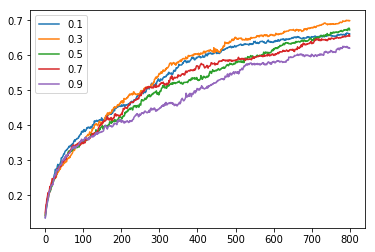

In [114]:
plt.plot(np.mean(xover01,axis=0),label='0.1')
plt.plot(np.mean(xover03,axis=0),label='0.3')
plt.plot(np.mean(xover05,axis=0),label='0.5')
plt.plot(np.mean(xover07,axis=0),label='0.7')
plt.plot(np.mean(xover09,axis=0),label='0.9')

plt.legend()

<ErrorbarContainer object of 3 artists>

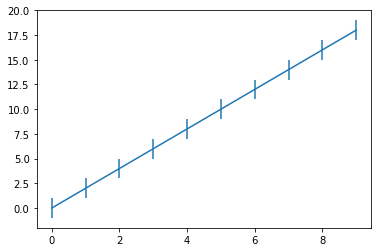

In [120]:
plt.errorbar(np.arange(10),2*np.arange(10),np.ones(10))

<ErrorbarContainer object of 3 artists>

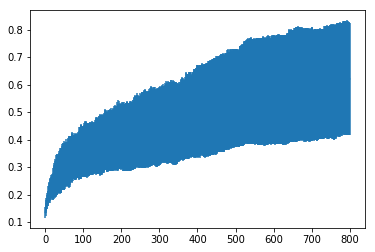

In [124]:
plt.errorbar(np.arange(801),np.mean(xover09,axis=0),np.std(xover09,axis=0))

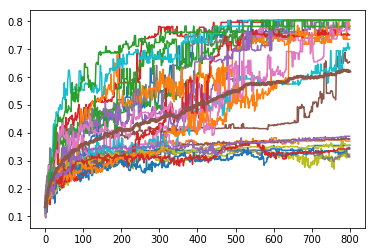

In [145]:
for a in range(25):
    plt.plot(np.array(xover09)[a,:])
plt.plot(np.mean(xover09,axis=0),lw=3)

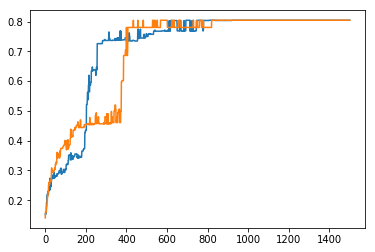

In [82]:
plt.plot(best_fitnesses01)
plt.plot(bf01)
#plt.plot(best_fitnesses05)
#plt.plot(best_fitnesses07)
#plt.plot(best_fitnesses09)

#plt.hlines(-1./theoretical_frequencies.dot(logfreqs),0,3000)

In [76]:
best_fitnesses01= np.copy(best_fitnesses)

In [1491]:
fitness(k1, encrypted_text)

36.11137160888612

In [1098]:
def ranks(array):
    values, counts = np.unique(array, return_counts = True)
    dictionary=dict(zip(np.array(values)[np.argsort(-counts)],range(1,len(values)+1)))
    return np.array([dictionary[a] for a in array])